In [60]:
# https://www.kaggle.com/code/serigne/stacked-regressions-top-4-on-leaderboard

In [61]:
# import dependencies

import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette() # Return a list of colors or 
                            # continuous colormap defining a palette.
import warnings
warnings.filterwarnings('ignore')

from scipy import stats
from scipy.stats import norm, skew

pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x))

from subprocess import check_output
print(check_output(["ls", "./Data"]).decode("utf8"))

data_description.txt
sample_submission.csv
test.csv
train.csv



In [62]:
# lets import train and test set
train = pd.read_csv('./Data/train.csv')
test = pd.read_csv('./Data/test.csv')

In [63]:
train.shape,test.shape

((1460, 81), (1459, 80))

In [64]:
train.head(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.000,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.000,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.000,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.000,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.000,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [65]:
test.head(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.000,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.000,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.000,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.000,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.000,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


- we wont needing the ID column, as we will be using default indexing

In [66]:
train.drop('Id',axis=1,inplace=True)
test.drop('Id',axis=1,inplace=True)

## Data Processing

### Outliers

Lets explore the outliers

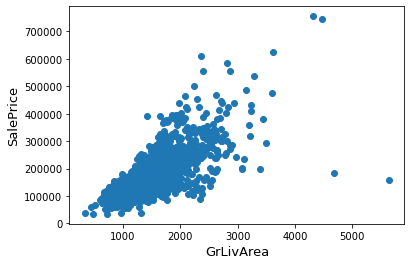

In [67]:
fig,ax = plt.subplots() # 1 row, 1 col by default
# Above grade (ground) living area square feet : GrLivArea
ax.scatter(x=train['GrLivArea'], y = train['SalePrice'])
plt.ylabel('SalePrice', fontsize = 13)
plt.xlabel('GrLivArea', fontsize = 13)
plt.show()

- We dont wanna delete all the outliers... but its good practice to delete extreme outliers

In [68]:
train = train.drop(train[(train['GrLivArea']>4000) & (train['SalePrice']<300000)].index)

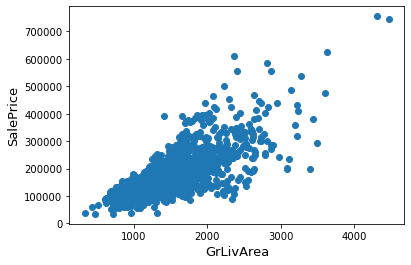

In [69]:
# Lets check theresult
fig, ax = plt.subplots()
ax.scatter(train['GrLivArea'], train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.show()

### Target Variable Analysis

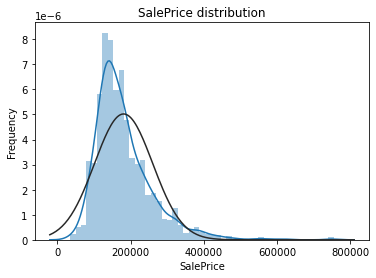

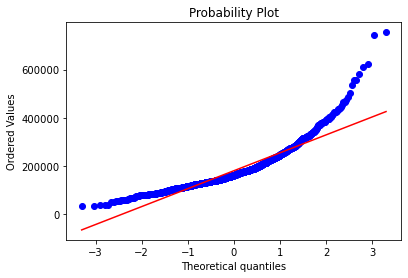

In [70]:
sns.distplot(train['SalePrice'], fit=norm);

# Get the fitted parameter used by the model
(mu,sigma) = norm.fit(train['SalePrice'])
mu, sigma

plt.ylabel('Frequency')
plt.title('SalePrice distribution')

# QQ plot
fig = plt.figure()
res = stats.probplot(train['SalePrice'],plot=plt)
plt.show()

- the distribution is right skewed!
- its good idea to make the data normally distributed!

<AxesSubplot:xlabel='SalePrice', ylabel='Density'>

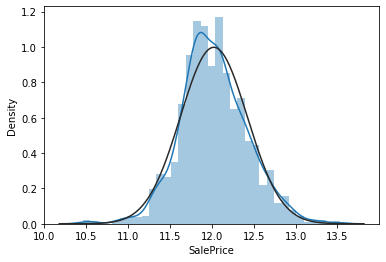

In [71]:
train['SalePrice'] = np.log1p(train['SalePrice'])
sns.distplot(train['SalePrice'], fit=norm)

In [72]:
# get the parameters
(mu,sigma) = norm.fit(train['SalePrice'])
mu, sigma

(12.024015155682552, 0.3995757283645756)

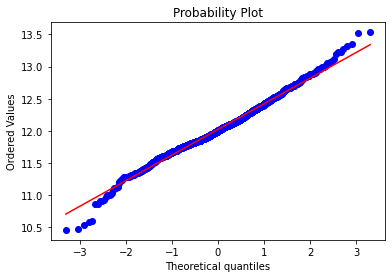

In [73]:
#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(train['SalePrice'], plot=plt)
plt.show()

### Feature Engineering

In [74]:
ntrain = train.shape[0]
ntest = test.shape[0]
y_train = train.SalePrice.values

all_data = pd.concat((train,test)).reset_index(drop=True)
all_data.drop(['SalePrice'],axis=1,inplace=True)
all_data.shape

(2917, 79)

#### Missing Data

In [75]:
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na==0].index).sort_values(ascending=False)[:30]

missing_data = pd.DataFrame({'Missing Ration' : all_data_na})
missing_data.head(20)

,Missing Ration
PoolQC,99.691
MiscFeature,96.400
Alley,93.212
Fence,80.425
FireplaceQu,48.680
LotFrontage,16.661
GarageFinish,5.451
GarageQual,5.451
GarageCond,5.451
GarageYrBlt,5.451


Text(0.5, 1.0, 'Percent missing data by feature')

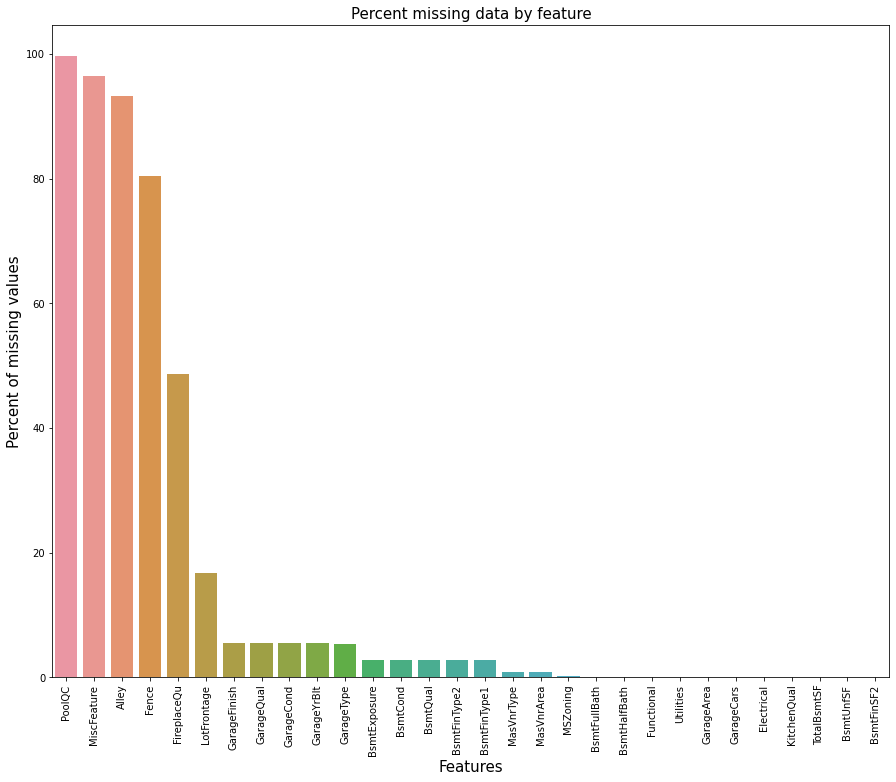

In [76]:
# Lets plot the result
f , ax = plt.subplots(figsize=(15,12))
plt.xticks(rotation = '90')
sns.barplot(x = all_data_na.index, y = all_data_na)
plt.xlabel('Features', fontsize=15)
plt.ylabel('Percent of missing values', fontsize = 15)
plt.title('Percent missing data by feature', fontsize = 15)

#### Data Correlation

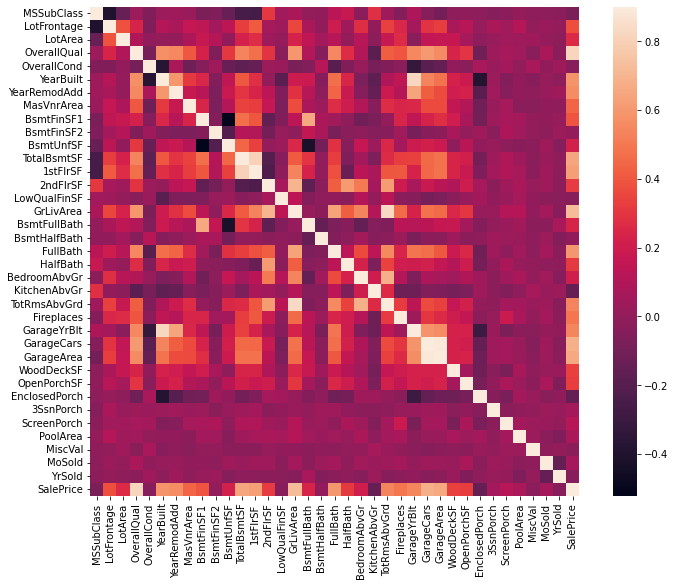

In [77]:
cormat = train.corr()
plt.subplots(figsize= (12,9))
sns.heatmap(cormat, vmax=0.9,square=True)
plt.show()

#### Imputing missing values

 - Some of the categorical variables has NA values which seemly mean None!

In [78]:
all_data['PoolQC'] = all_data['PoolQC'].fillna('None')

In [79]:
all_data["MiscFeature"] = all_data["MiscFeature"].fillna("None")

In [80]:
all_data["Alley"] = all_data["Alley"].fillna("None")

In [81]:
all_data["Fence"] = all_data["Fence"].fillna("None")

In [82]:
all_data["FireplaceQu"] = all_data["FireplaceQu"].fillna("None")

- **LotFrontage**: Linear feet of street connected to property

In [83]:
# Group by neighbourhood and fill in missing value by the median LotFrontage of all
# the neighbourhood

all_data["LotFrontage"] = all_data.groupby("Neighborhood")["LotFrontage"].transform(
    lambda x: x.fillna(x.median()))

- GarageType, GarageFinish, GarageQual and GarageCond : Replacing missing data with None

In [84]:
for col in ('GarageType','GarageFinish','GarageQual','GarageCond'):
    all_data[col] = all_data[col].fillna('None')

- **GarageYrBlt, GarageArea and GarageCars**: Replacing missing data with 0 (Since no garage = no cars in such garage)

In [85]:
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    all_data[col] = all_data[col].fillna(0)

- if you dont have basement, these features will have value 0

In [86]:
for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
    all_data[col] = all_data[col].fillna(0)

In [87]:
for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    all_data[col] = all_data[col].fillna('None')

In [88]:
all_data["MasVnrType"] = all_data["MasVnrType"].fillna("None")
all_data["MasVnrArea"] = all_data["MasVnrArea"].fillna(0)

- MSZoning : Identifies the general zoning classification of the sale.
- Lets fill the missing values with the most occuring one

In [89]:
# returns modes of the series in descending order
all_data['MSZoning'] = all_data['MSZoning'].fillna(all_data['MSZoning'].mode()[0])

- Utilities: This is a contant value series... better delete it!

In [90]:
all_data = all_data.drop(['Utilities'], axis=1)

- **Functional**: data description says NA means typical

In [91]:
all_data["Functional"] = all_data["Functional"].fillna("Typ")

- **Electrical**: only one NA value.. replacing it with most occuring!

In [92]:
all_data['Electrical'] = all_data['Electrical'].fillna(
    all_data['Electrical'].mode()[0]
)

- Same with these features

In [93]:
for col in ('KitchenQual','Exterior1st','Exterior2nd','SaleType'):
    all_data[col] = all_data[col].fillna(
        all_data[col].mode()[0]
    )

In [94]:
all_data['MSSubClass'] = all_data['MSSubClass'].fillna("None")

- Lets recheck again the missing values ratios

In [95]:
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data.head()

,Missing Ratio


### More Feature Engineering!

**Transforming some numerical variables that are categorical**

In [96]:
# MSSubClass: Identifies the type of dwelling involved in the sale.
all_data['MSSubClass'].value_counts()

20     1079
60      573
50      287
120     182
30      139
70      128
160     128
80      118
90      109
190      61
85       48
75       23
45       18
180      17
40        6
150       1
Name: MSSubClass, dtype: int64

- This is certainly a catergorical variable; but the type of data is int in the dataset

In [97]:
all_data['MSSubClass'] = all_data['MSSubClass'].apply(str)

In [98]:
all_data['MSSubClass'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 2917 entries, 0 to 2916
Series name: MSSubClass
Non-Null Count  Dtype 
--------------  ----- 
2917 non-null   object
dtypes: object(1)
memory usage: 22.9+ KB


In [99]:
# Rates the overall condition of the house
all_data['OverallCond'].value_counts()

5    1643
6     531
7     390
8     144
4     101
3      50
9      41
2      10
1       7
Name: OverallCond, dtype: int64

In [100]:
all_data['OverallCond'] = all_data['OverallCond'].astype(str)

In [101]:
#Year and month sold are transformed into categorical features.
all_data['YrSold'] = all_data['YrSold'].astype(str)
all_data['MoSold'] = all_data['MoSold'].astype(str)

- As now, we have categorical variables that are represented in the dataset as object or str we need to convert them to numbers... we can use Label Encoding for this task

In [102]:
from sklearn.preprocessing import LabelEncoder
cols = (
    'FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 
    'ExterQual', 'ExterCond','HeatingQC', 'PoolQC', 'KitchenQual', 'BsmtFinType1', 
    'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 'GarageFinish', 'LandSlope',
    'LotShape', 'PavedDrive', 'Street', 'Alley', 'CentralAir', 'MSSubClass', 'OverallCond', 
    'YrSold', 'MoSold'
)

for c in cols:
    le = LabelEncoder()
    le.fit_transform(list(all_data[c].values))

all_data.shape

(2917, 78)

#### Adding one more important feature

Since area related features are very important to determine house prices, we add one more feature which is the total area of basement, first and second floor areas of each house

In [103]:
# Adding total sqfootage feature
all_data['TotalSF'] = all_data['TotalBsmtSF']+all_data['1stFlrSF']+all_data['2ndFlrSF']

- Skewed featureS:

In [104]:
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index

# check the skewness of all numerical features
skewed_feats = all_data[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(
    ascending=False
)
skewness = pd.DataFrame({'Skew': skewed_feats})
skewness.head(10)

,Skew
MiscVal,21.940
PoolArea,17.689
LotArea,13.109
LowQualFinSF,12.085
3SsnPorch,11.372
KitchenAbvGr,4.301
BsmtFinSF2,4.145
EnclosedPorch,4.002
ScreenPorch,3.945
BsmtHalfBath,3.930


- Box Cox Transformation to remedy

In [105]:
skewness = skewness[abs(skewness) > 0.75]
print("There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))

from scipy.special import boxcox1p
skewed_features = skewness.index
lam = 0.15
for feat in skewed_features:
    #all_data[feat] += 1
    all_data[feat] = boxcox1p(all_data[feat], lam)
    
#all_data[skewed_features] = np.log1p(all_data[skewed_features])

There are 33 skewed numerical features to Box Cox transform


In [106]:
all_data = pd.get_dummies(all_data)
print(all_data.shape)

(2917, 338)


In [107]:
train = all_data[:ntrain]
test = all_data[ntrain:]

### Modelling

#### Import libraries

In [108]:
from sklearn.linear_model import ElasticNet, Lasso, BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin,clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb

In [117]:
#Validation function
n_folds = 5

def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(train.values)
    rmse= np.sqrt(-cross_val_score(model, train.values, y_train, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

### Base Model

- Lasso Regression:

This model is very sensitive to outliers.. thus we need to use RobustScaler

In [110]:
lasso = make_pipeline(
    RobustScaler(),
    Lasso(alpha=0.0005,random_state=1)
)

- Elastic Net Regression

In [111]:
ENet = make_pipeline(
    RobustScaler(),
    ElasticNet(alpha=0.0005,l1_ratio=.9,random_state=3)
)

- Kernel Ridge Regression:

In [112]:
KRR = KernelRidge(
    alpha=0.6,
    kernel='polynomial',
    degree=2,
    coef0=2.5
)

- Gradient Boosting Regression:

Use **huber loss** to make it robust to outliers


In [123]:
GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)

- XGBoost

In [114]:
model_xgb = xgb.XGBRegressor(
    colsample_bytree = 0.4603,
    gamma = 0.0468,
    learning_rate = 0.05,
    max_depth = 3,
    min_child_weight=1.7817,
    n_estimators=2200,
    reg_alpha=0.4640,
    reg_lambda=0.8571,
    subsample=0.5213,
    silent=1,
    random_state =7,
    nthread = -1
)

- LightGBM:

In [115]:
model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)

#### Base Model Scores

In [118]:
score = rmsle_cv(lasso)
print("\nLasso score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))


Lasso score: 0.1112 (0.0066)



In [119]:
score = rmsle_cv(ENet)
print("ElasticNet score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

ElasticNet score: 0.1112 (0.0067)



In [120]:
score = rmsle_cv(KRR)
print("Kernel Ridge score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Kernel Ridge score: 0.1153 (0.0054)



In [124]:
score = rmsle_cv(GBoost)
print("Gradient Boosting score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Gradient Boosting score: 0.1187 (0.0076)



In [122]:
score = rmsle_cv(model_xgb)
print("Xgboost score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

[12:28:55] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[12:29:08] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[12:29:20] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting fl

In [125]:
score = rmsle_cv(model_lgb)
print("LGBM score: {:.4f} ({:.4f})\n" .format(score.mean(), score.std()))

[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6

#### Stacking Models

**Simplest Stacking Approach: Averaging base Models**

In [126]:
class AveragingModels(BaseEstimator,RegressorMixin,TransformerMixin):
    def __init__(self,models):
        self.models = models
    
# define clones of the original models to fit the data
def fit(self, X, y):
    self.models_ = [clone(x) for x in self.models]

    # Trained cloned base models
    for model in self.models_:
        model.fit(X,y)

    return self

# do the predictions for the cloned models and average them
def predict(self, X):
    predictions = np.column_stack([
        model.predict(X) for model in self.models_
    ])

    return np.mean(predictions, axis=1)